# Ignorance isn't Bliss (Blog Post 2)

In this notebook, we investigate whether we can improve the fairness of a machine learning model by removing protected or sensitive attribute labels (i.e. attributes that the organisation responsible for the system does not intend to discriminate against because of societal norms, law or policy - for example, gender) from the data. Intuitively, one might expect this to make the model ignorant or unaware of gender, and therefore lead to more equitable outcomes.

In [1]:
# Import libraries:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as pl
%matplotlib inline

### Dataset

Let’s look at the behaviour of a machine learning system on an illustrative data set. An appropriate set of unit-records have already been simulated using the code [here](https://github.com/gradientinstitute/demo_code/blob/master/blog_post_2/make_data.ipynb), so we simply need to parse the file: 

In [2]:
# Load the data
data = pd.read_csv('unit_records.csv')
n = data.shape[0]

# And split into training and testing fractions
train_frac = 0.8
n_train = int(n * train_frac)
train = slice(0, n_train)
test = slice(n_train, n)

# The training targets are whether applicants were hired or not
hired = data.Hired.values == "Yes"

# And the key features
experience = data.Experience.values.astype(float)
is_male = data.Gender.values == "Male"

display(data.loc[[898, 2343, 2398, 5906, 9394]])


,Experience,Gender,Hired
898,14,Male,No
2343,6,Male,No
2398,16,Female,Yes
5906,16,Male,Yes
9394,15,Male,No


### Data Quality

Now we can investigate the relationship between experience and the label (hired / not hired) in terms of distribution and correlation:

Experience-hiring correlation: 0.49


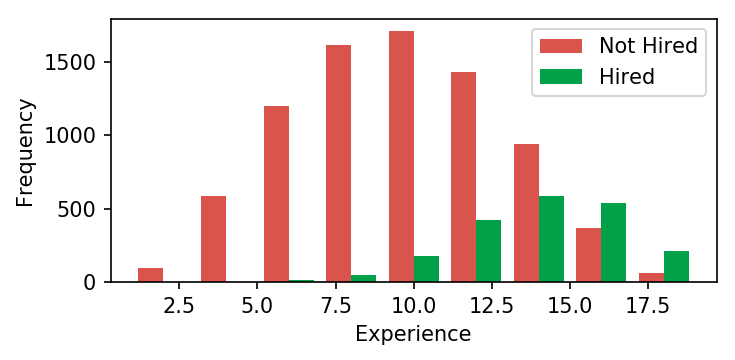

Gender-hiring correlation: 0.06


In [3]:
print("Experience-hiring correlation: {:.2f}".format( 
      np.corrcoef(experience[train], hired[train])[0,1]))

binx = np.linspace(0, 20, 11)
yi, _ = np.histogram(experience[train][~hired[train]], bins=binx)
ye, _ = np.histogram(experience[train][hired[train]], bins=binx)
binx = .5 * (binx[1:] + binx[:-1])

pl.figure(figsize=(5,2.5), dpi=150)
pl.xlabel("Experience")
pl.ylabel("Frequency")
pl.hist([experience[~hired], experience[hired]], bins=binx,
        label=['Not Hired', 'Hired'],
        color=['#d9544d', '#01a049'])
pl.legend()
pl.tight_layout()
pl.show()

print("Gender-hiring correlation: {:.2f}".format( 
      np.corrcoef(is_male[train], hired[train])[0,1]))

### A standard model

Clearly there is a relationship here, so lets go ahead and build a fairly standard classification model based on a scikit learn logistic regressor. We will train on the first 80% of the data, and test on the last 20%:

Accuracy (Standard Model):


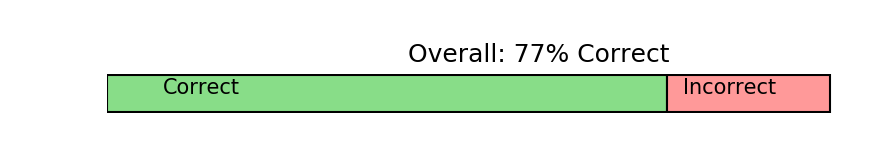

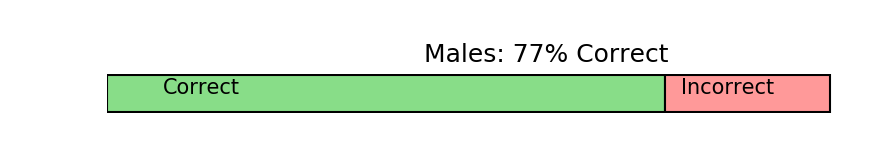

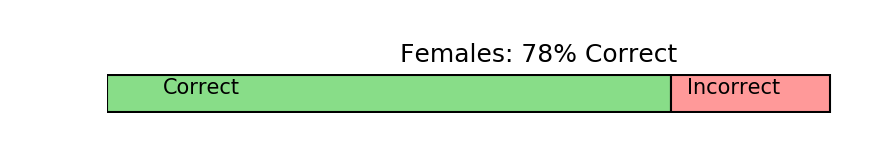

In [4]:
X_full = np.array([experience, is_male]).T
standard_model = LogisticRegression(class_weight='balanced')
standard_model.fit(X_full[train], hired[train])
select = standard_model.predict(X_full[test])

checks = [
    ("Overall", slice(None)),
    ("Males", is_male[test]),
    ("Females", ~is_male[test]),
]

# Check the accuracy
print("Accuracy (Standard Model):")

def stack(*parts):
    """Draw a horizontally stacked bar graph."""
    colors = {
        "lred": "#FF9999",  # pink
        "green": "#009900",  # Green
        "red": "#BB0000",  # Red
        "lgreen": "#88DD88",  # Light green
        "lblue": "#9999FF",  # Blue
    }
    pl.figure(dpi=150)  
    last = 0
    for name, col, vals in parts:
        count = vals.mean()
        pl.barh(0, count, .05, left=last, color=colors[col],
               edgecolor='k')
        pl.text(last + 0.1 * count, 0, name)
        last += count
    pl.axis('image')
    pl.axis('off')
    pl.tight_layout()

    
def check_accuracy(select):
    """Draw plots assessing sub-group accuracy."""
    for name, filt in checks:
        hire = hired[test][filt]
        pred = select[filt]
        acc = np.mean(hire==pred)
        stack(
            ("Correct", "lgreen", (pred == hire)),
            ("Incorrect", "lred", (pred != hire)),
        )
        pl.title("\n{:>20s}: {:.0f}% Correct".format(name, 100.*acc))
        pl.show()
        
check_accuracy(select)

### Standard model: Fairness of outcomes

We know that there is no inherent difference in suitability of males and females in the scenario. We controlled for this when we simulated the data, because gender and suitability were drawn from independent random distributions. We can therefore examine the fairness of outcomes in this case.

The accuracy of the selections above looked promising. The model is even slightly more accurate on Females, the group that we were worried might be disadvantaged.

However, if we look at the outcomes in terms of the gender fraction of applicants we see a different story:


Composition (Standard Model):


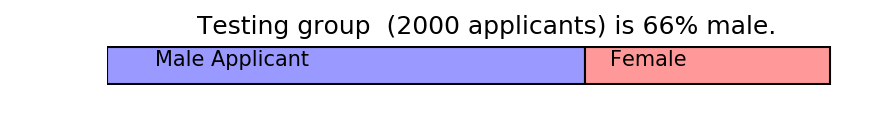

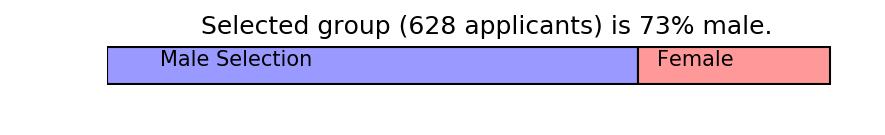


Recall (Standard Model):


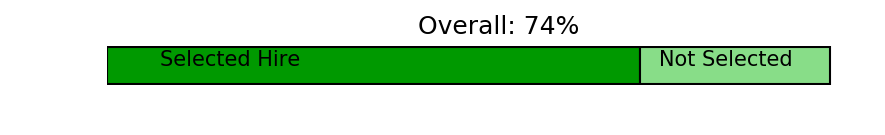

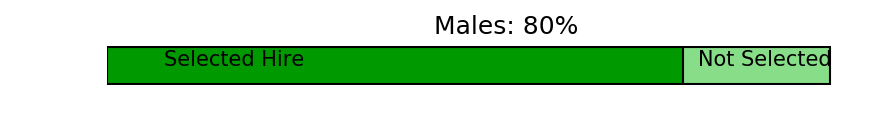

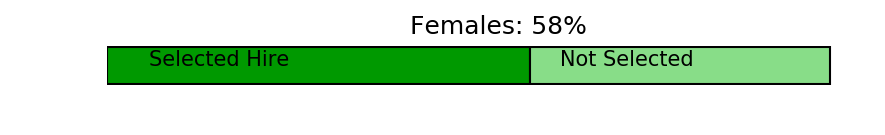

In [5]:
def check_composition(select):
    """Visualise the gender composition of the selected cohort and the
    total cohort."""
    n_selected = np.sum(select)
    male = is_male[test]
    stack(
         ("Male Applicant", "lblue", male),
         ("Female", "lred", ~male),
    )
    pl.title("Testing group  ({} applicants) is {:.0f}% male.".format(
        n - n_train, 100. * is_male[test].mean()))
    pl.show()

    male = is_male[test][select]
    stack(
         ("Male Selection", "lblue", male),
         ("Female", "lred", ~male),
    )
    pl.title("Selected group ({} applicants) is {:.0f}% male.".format(
        n_selected, 100. * male.mean()))

    pl.show()


def check_recall(selection):
    """Visualise the recall of the hired cohort."""
    for name, filt in checks:
        true = hired[test][filt].astype(bool)
        pred = selection[filt]
        recall = pred[true]
        stack(
            ("Selected Hire", "green", recall),
            ("Not Selected", "lgreen", ~recall),
        )
        pl.title("{:>10s}: {:.0f}%".format(name, 100.*np.mean(pred[true])))

print("\nComposition (Standard Model):")
check_composition(select)
print("\nRecall (Standard Model):")
check_recall(select)

It turns out that we are selecting a disproportionately male cohort - clearly females are being disadvantaged.

It’s possible that this discrepancy is due to a historical bias against women in the training labels and is not consistent with the company’s notion of fair outcomes. When there is bias in the training labels, a model’s predictions will perpetuate it because the model has no wider knowledge to discern actual suitability from discrimination.




We have also checked the recall - the fraction of historically employed individuals that the algorithm would select. While 100% recall doesn't neccessarily mean fair (as there is likely bias in the historical outcomes too), this result does tell us that the model would disadvantage women, recovering less of the "good" females than the "good" males.

## Fairness through unawareness

An intuitive approach that you might adopt in an attempt to remedy this issue (and an approach that we’ve commonly seen used in practice) is to remove the protected attributes from the data so the model is ignorant or “unaware” of race or gender. Let’s see what impact this has on the model.

### Unaware model

Let's train a model that is unaware of gender, by removing the `is_male` column from the data and running the same checks:

Accuracy (unaware model):


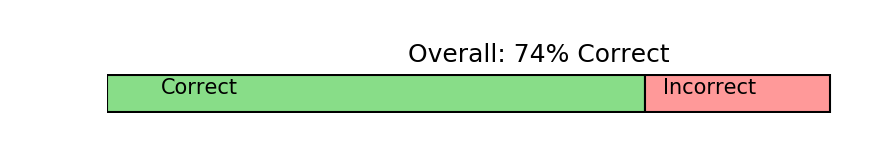

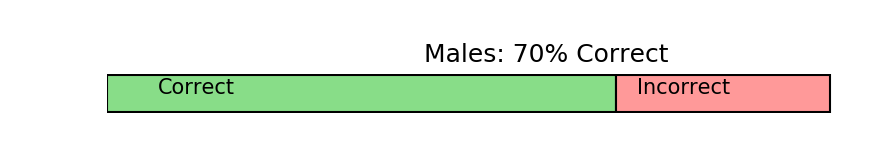

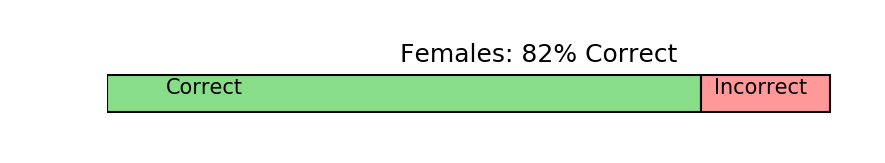

In [6]:
# Lets try the "intuitive fix" of deleting gender
X_unaware = np.array([experience]).T # Remove gender from model
unaware_model = LogisticRegression(class_weight='balanced')
unaware_model.fit(X_unaware[train], hired[train])
select_new = unaware_model.predict(X_unaware[test])

# Whats the accuracy and recall now:
print("Accuracy (unaware model):")

check_accuracy(select_new)


### Unaware model: Fairness

We notice a drop in accuracy - by removing gender we have given the model less information to learn from. Let's investigate whether we have more fair outcomes in return:

Selection composition (unaware model)


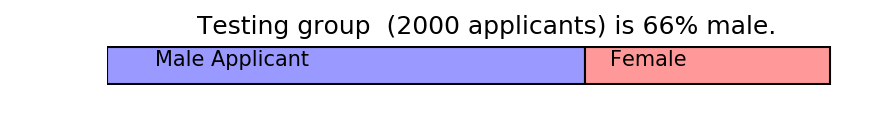

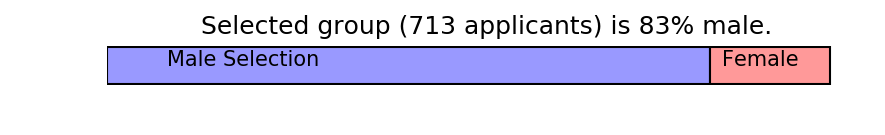


Recall (unaware model):


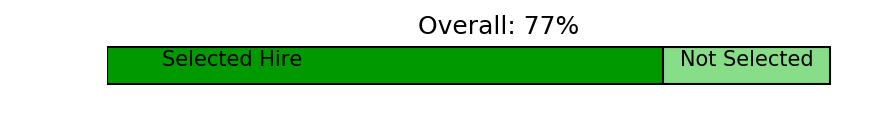

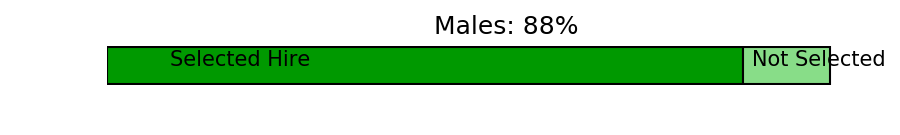

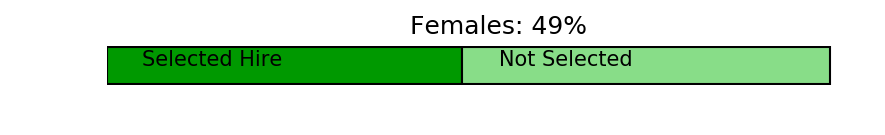

In [7]:
# Check the gender balance for the blind regressor 
print("Selection composition (unaware model)")
check_composition(select_new)

# This is related to the recall of eligible individuals
print("\nRecall (unaware model):")
check_recall(select_new)

So despite the intuition that removing the protected feature from the set would help remove discriminatory historical bias, we’ve actually made things considerably worse for women.

## What Went Wrong?

Our intuition has led us astray - the outcomes were much worse for women when we deleted gender from the data.

### Is there a conflation of gender and experience?

Firstly, look at the distribution of experience by gender:


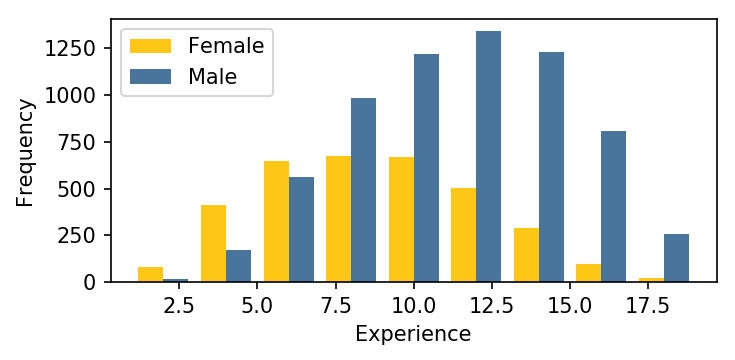

In [8]:
# Explore the relationship between gender and experience:
pl.figure(figsize=(5,2.5), dpi=150)
#pl.title("Experience vs Gender")
pl.xlabel("Experience")
pl.ylabel("Frequency")
pl.hist(
    [experience[~is_male], experience[is_male]],
    bins=binx,
    label=['Female',  'Male'],
    color=['#fec615', '#49759c'])
pl.legend()
pl.tight_layout()
pl.show()

We can see that men have a higher average experience than women. While experience and gender is a relatively unsurprising relationship, we would in general expect a different joint-distribution of covariates when a population is partitioned by gender, race, age or other factors. In many real datasets with rich feature sets, we would expect to predict the sensitive attributes with very high accuracy through correlations with the other features. In this case, how recoverable is gender?


### Can we recover gender from the experience feature?


Lets train another simple logistic regression classifier to find out. This time, the input is experience, and the target output is gender. We'll train the model on the same training group (80% of the data), and validate on the remaining 20%: 

In [9]:
# In fact, can we recover gender from experience?
gender_clf = LogisticRegression(class_weight='balanced')
yg = is_male.astype(int)
gender_clf.fit(X_unaware[train], yg[train])
prediction = gender_clf.predict(X_unaware[test])
accuracy = (prediction == yg[test]).mean()
print("Accuracy recovering protected attribute: {:.0f}%".format(
    100*accuracy))


Accuracy recovering protected attribute: 66%


We can recover gender - not as accurately as we can predict whether an applicant will be hired, but much better than a random guess.

### Why was the standard model better?

While not perfect, the standard model was actually leading to more equitable gender outcomes than the unaware model. Lets inspect its internal weights to see what was going on:

In [10]:
print("Original model Weights:", end="\n\n\t")
print("Experience: {:.2f}\n\tIs_Male:   {:.2f}".format(*standard_model.coef_.ravel()))
print("\tIntercept: {:.2f}".format(standard_model.intercept_.ravel()[0]))

Original model Weights:

	Experience: 0.56
	Is_Male:   -1.03
	Intercept: -5.69


We can see that the equation used by the standard model to predict the probability that an applicant will be hired was given by:

$$\large \phi ( 0.56 e - 1.03 m - 5.69 ),$$

where $\phi$ is the logistic sigmoid function, $e$ is the experience feature and $m$ is the `is_male` indicator feature. The negative weight on `is_male` indicates that male probability-of-selection was being *reduced* to compensate for the effect of their higher average experience. This is conceptually equivalent to having a different male model and female model.